In [1]:
import warnings
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from transformers import AutoTokenizer, PreTrainedTokenizerFast, AutoModelForCausalLM, logging
from typing import Dict, Tuple
from peft import PeftModel

warnings.filterwarnings("ignore", message="Setting `pad_token_id` to `eos_token_id`:.*")
logging.set_verbosity_error()


In [2]:
def evaluate_llm_classifier(base_model_path: str, lora_adapter_path: str, test_data: pd.DataFrame, tokenizer: PreTrainedTokenizerFast) -> Tuple[Dict[str, float | int], Dict[str, float]]:

    base_model = AutoModelForCausalLM.from_pretrained(
        base_model_path,
        torch_dtype=torch.bfloat16,
        device_map="auto"
    )

    model = PeftModel.from_pretrained(
        base_model,
        lora_adapter_path,
        torch_dtype=torch.bfloat16,
        device_map="auto"
    )

    special_tokens = {
        "additional_special_tokens": [
            "<|start_header_id|>",
            "<|end_header_id|>",
            "<|eot_id|>"
        ]
    }
    tokenizer.add_special_tokens(special_tokens)
    base_model.resize_token_embeddings(len(tokenizer))

    tokenizer.chat_template = None

    tokenizer.chat_template = """<|begin_of_text|>{% for message in messages %}<|start_header_id|>{{ message['role'] }}<|end_header_id|>{{ message['content'] }}<|eot_id|>{% endfor %}"""

    true_labels = []
    predicted_labels = []
    format_violations = []

    for _, row in test_data.iterrows():

        messages = [
            {"role": "system", "content": row["system"]},
            {"role": "user", "content": row["user"]},
            {"role": "assistant", "content": ""}
        ]

        input_ids = tokenizer.apply_chat_template(
            messages,
            return_tensors="pt",
            add_generation_prompt=True
        ).to(model.device)

        with torch.no_grad():
            outputs = model.generate(
                input_ids=input_ids,
                do_sample=False,
                temperature=None,
                max_new_tokens=1,
                top_p=None,
                eos_token_id=tokenizer.convert_tokens_to_ids("<|eot_id|>"),
                pad_token_id=None
            )

        input_length = input_ids.size(1)
        prediction = tokenizer.decode(outputs[0][input_length:], skip_special_tokens=True)
        first_word = prediction.split('<')[0].strip().lower()

        print(f"Cleaned prediction: {first_word}")

        pred_label = "true" in prediction.lower()
        true_label = row["assistant"] == True

        if first_word not in ["true", "false"]:
            format_violations.append(first_word)

        true_labels.append(true_label)
        predicted_labels.append(pred_label)

    true_labels = [int(label) for label in true_labels]
    predicted_labels = [int(label) for label in predicted_labels]

    format_violation_score = (1 - len(format_violations) / len(test_data))

    metrics = {
        "accuracy": accuracy_score(true_labels, predicted_labels),
        "precision": precision_score(true_labels, predicted_labels),
        "recall": recall_score(true_labels, predicted_labels),
        "f1_score": f1_score(true_labels, predicted_labels),
        "format_violations": len(format_violations),
        "format_violation_score": format_violation_score,
        "true_labels": true_labels,
        "predicted_labels": predicted_labels,
    }

    evaluation_confusion_matrix = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(10,8))
    sns.heatmap(evaluation_confusion_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()

    return format_violations, metrics


In [3]:
test_df = pd.read_csv("../processed_data/test.csv")

In [4]:
base_model_path = "../models/llama_models/llama-3.2-3B"

In [5]:
tokenizer = AutoTokenizer.from_pretrained(base_model_path, trust_remote_code=True)

# Checkpoint 467

In [6]:
checkpoint_1868_adapter_path = "../models/tuned_models/llama-3.2-3B-phishing-classifier-causal-v2/checkpoint-1868"

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Cleaned prediction: true
Cleaned prediction: false
Cleaned prediction: false
Cleaned prediction: false
Cleaned prediction: false
Cleaned prediction: false
Cleaned prediction: true
Cleaned prediction: true
Cleaned prediction: false
Cleaned prediction: true
Cleaned prediction: false
Cleaned prediction: false
Cleaned prediction: false
Cleaned prediction: false
Cleaned prediction: false
Cleaned prediction: true
Cleaned prediction: false
Cleaned prediction: false
Cleaned prediction: true
Cleaned prediction: true
Cleaned prediction: false
Cleaned prediction: true
Cleaned prediction: false
Cleaned prediction: false
Cleaned prediction: true
Cleaned prediction: false
Cleaned prediction: false
Cleaned prediction: true
Cleaned prediction: true
Cleaned prediction: true
Cleaned prediction: true
Cleaned prediction: true
Cleaned prediction: false
Cleaned prediction: false
Cleaned prediction: true
Cleaned prediction: false
Cleaned prediction: true
Cleaned prediction: false
Cleaned prediction: false
Cl

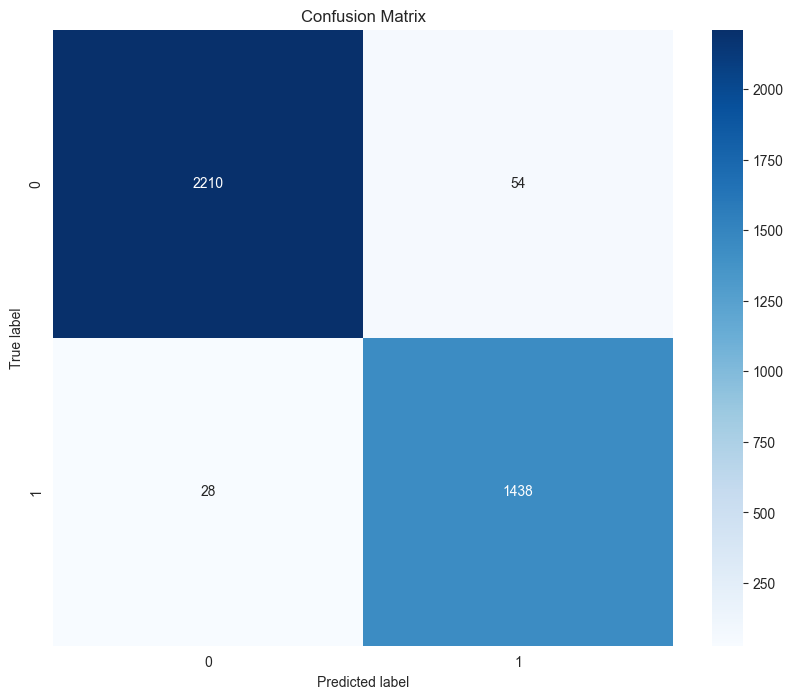

In [7]:
checkpoint_1868_format_violations, checkpoint_1858_metrics = evaluate_llm_classifier(
    base_model_path=base_model_path,
    lora_adapter_path=checkpoint_1868_adapter_path,
    test_data=test_df,
    tokenizer=tokenizer
)

In [8]:
cls_report = classification_report(checkpoint_1858_metrics["true_labels"], checkpoint_1858_metrics["predicted_labels"], target_names=["Safe", "Phishing"])

print(cls_report)

              precision    recall  f1-score   support

        Safe       0.99      0.98      0.98      2264
    Phishing       0.96      0.98      0.97      1466

    accuracy                           0.98      3730
   macro avg       0.98      0.98      0.98      3730
weighted avg       0.98      0.98      0.98      3730



In [9]:
print(f"Accuracy: {checkpoint_1858_metrics['accuracy']}")
print(f"Precision: {checkpoint_1858_metrics['precision']}")
print(f"Recall: {checkpoint_1858_metrics['recall']}")
print(f"F1-score: {checkpoint_1858_metrics['f1_score']}")
print(f"Format Violations: {checkpoint_1858_metrics['format_violations']}")
print(f"Format Violation Score: {checkpoint_1858_metrics['format_violation_score']}")

Accuracy: 0.9780160857908847
Precision: 0.9638069705093834
Recall: 0.9809004092769441
F1-score: 0.9722785665990534
Format Violations: 0
Format Violation Score: 1.0
